# Integration of BCR and GEX data

## Introduction

10x BCR (B cell receptor) data and 10x GEX (gene expression) data can borrow information from each other for an improved analysis. This tutorial demonstrates a few approaches to integrating these data types along with examples on how the new information can be used. The example datasets (**BCR.data.rds** and **GEX.data.rds**) can be downloaded in a zip file from [here](https://yale.box.com/shared/static/6s8gzxxpfb3vmwx2izn9qur9teultzvu.zip).

In [1]:
# make sure the environment is clear
rm(list = ls())

# load the needed libraries
packages <- c("cowplot", "dplyr", "ggplot2", "Seurat")
for (n in 1:length(packages)) {
    suppressPackageStartupMessages(library(packages[n], character.only = TRUE))
}

path.work <- file.path("..", "immcantation-BCR-Seurat-tutorial") # change this to fit your own directory structure

In this tutorial, we will integrate the BCR and GEX data by using the cell barcodes. However, since cell barcodes can be duplicated in multiple samples, we suggest concatenating the sample ids with the cell ids in order to ensure the uniqueness of cell barcodes across multiple samples. The sample ids can be added as a prefix to the existing cell ids when the GEX data is being processed with a Seurat command such as `gex_obj <- RenameCells(object = gex_obj, add.cell.id = sample)`. 

*Note: We have already added the sample ids to the cell ids as such in the example GEX data.*

In [2]:
# read in the data
gex_obj <- readRDS(file.path(path_data, "GEX.data.rds"))
bcr_data <- readRDS(file.path(path_data, "BCR.data.rds"))

# concatenate the sample id (sample) and cell id (cell_id) in the BCR data
bcr_data <- bcr_data %>% rowwise() %>%
            mutate(cell_id_unique = paste(sample, strsplit(cell_id, split = "-")[[1]][1], sep = "_"))

## Integration of BCR data with the GEX Seurat object

The meta.data data slot in the Seurat object contains metadata for each cell and is a good place to hold information from BCR data.
* For example, we can indicate if a cell in the GEX data has a corresponding BCR or not by adding a column called “has_BCR”.
* If the column “has_BCR” is true, then we can add other useful BCR data information such as clonal lineage, mutation frequency, isotype, etc. to the metadata slot.

*explain use same airr standard col names, just prefix with BCR_*

### Create the new metadata columns

In [37]:
# match cell ids between GEX and BCR data
match_index <- match(Cells(gex_obj), bcr_data$cell_id_unique)

# create BCR-related metadata columns (with NAs if there isn't a corresponding BCR)
gex_obj$contains_bcr <- !is.na(match_index)

clone_id <- bcr_data$clone_id
gex_obj$bcr_clone_id <- unlist(lapply(match_index, function(x){ifelse(is.na(x), NA, clone_id[x])}))

mu_freq <- bcr_data$mu_freq
gex_obj$bcr_mu_freq <- unlist(lapply(match_index, function(x){ifelse(is.na(x), NA, mu_freq[x])}))

isotype <- bcr_data$isotype 
gex_obj$bcr_isotype <- unlist(lapply(match_index, function(x){ifelse(is.na(x), NA, isotype[x])}))

# example of the new columns
ncol_meta <- ncol(gex_obj[[]])
gex_obj[[]][, (ncol_meta-3):ncol_meta] %>% slice_sample(n = 5)

,contains_bcr,bcr_clone_id,bcr_mu_freq,bcr_isotype
,<lgl>,<int>,<dbl>,<chr>
P05_FNA_2_5_Y1_CGTAGGCTCGGTCTAA,TRUE,92717,0.07638889,IgG
P05_FNA_60_Y1_CCCTCCTGTTGTTTGG,TRUE,80371,0.01736111,IgG
P05_FNA_2_0_Y1_TCTGAGACAGACACTT,TRUE,72948,0.02749141,IgA
P05_FNA_2_0_Y1_CTCGTCATCTCTGAGA,TRUE,132807,0.03125000,IgM
P05_FNA_3_12_Y1_CCACTACAGATCCTGT,FALSE,NA,NA,NA


### Highlight BCR cells in the GEX UMAP

After we integrate the BCR data into the Seurat object, we can highlight BCR cells in a GEX UMAP plot to check if annotations based upon biomarker gene expression are accurate or not.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



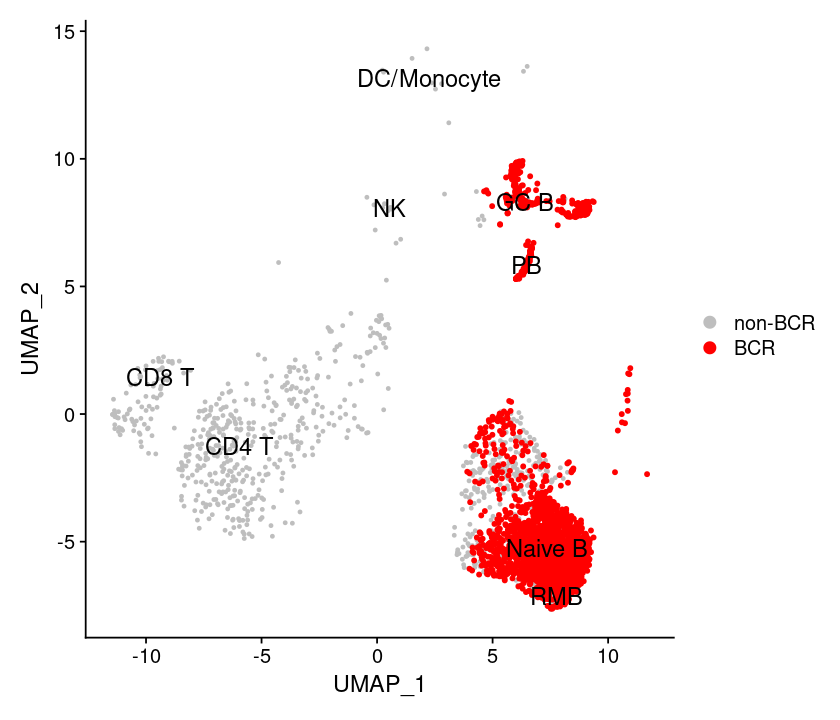

In [50]:
highlighted_cells <- Cells(gex_obj)[which(gex_obj$contains_bcr)]

options(repr.plot.width = 7, repr.plot.height = 6)
DimPlot(object = gex_obj, reduction = "umap", cells.highlight = highlighted_cells, 
        label = TRUE, label.size = 5, pt.size = 0.7) +
        scale_color_manual(labels = c("non-BCR", "BCR"), values = c("gray", "red"))

As we can see, there is a very good correlation between the BCR cells (in red) and the clusters labeled as B cells.

*UMAP note: DC = dendritic cells, NK = natural killer cells, PB = plasmablasts, GC B = germinal center B cells, RMB =*

## Integration of GEX cell annotations in the BCR data 

The annotatation information of B cells (such as sub-types of B cells and their associated UMAP coordinates) identified by the GEX data can be integrated into BCR data.

### Add GEX information to the BCR data

In [53]:
# match cell ids between BCR and GEX data
match_index <- match(bcr_data$cell_id_unique, Cells(gex_obj))

# create GEX-related columns (with NAs if there isn't a corresponding GEX cell embedding)
bcr_data$has_gex <- !is.na(match_index)

umap_1 <- gex_obj@reductions$umap@cell.embeddings[, 1]
bcr_data$gex_umap_1 = unlist(lapply(match_index, function(x){ifelse(is.na(x), NA, umap_1[x])}))

umap_2 <- gex_obj@reductions$umap@cell.embeddings[, 2]
bcr_data$gex_umap_2 = unlist(lapply(match_index, function(x){ifelse(is.na(x), NA, umap_2[x])}))

cell_annotation <- as.character(Idents(gex_obj)) # annotated GEX clusters
bcr_data$gex_annotation = unlist(lapply(match_index, function(x){ifelse(is.na(x), NA, cell_annotation[x])}))

# remove unannoted cells
bcr_data <- filter(bcr_data, !is.na(gex_annotation))

### Identify GEX clusters in the BCR UMAP

Using the annotated information, we can layout cells from the BCR data in a UMAP plot color-coded by the B cell subtypes.

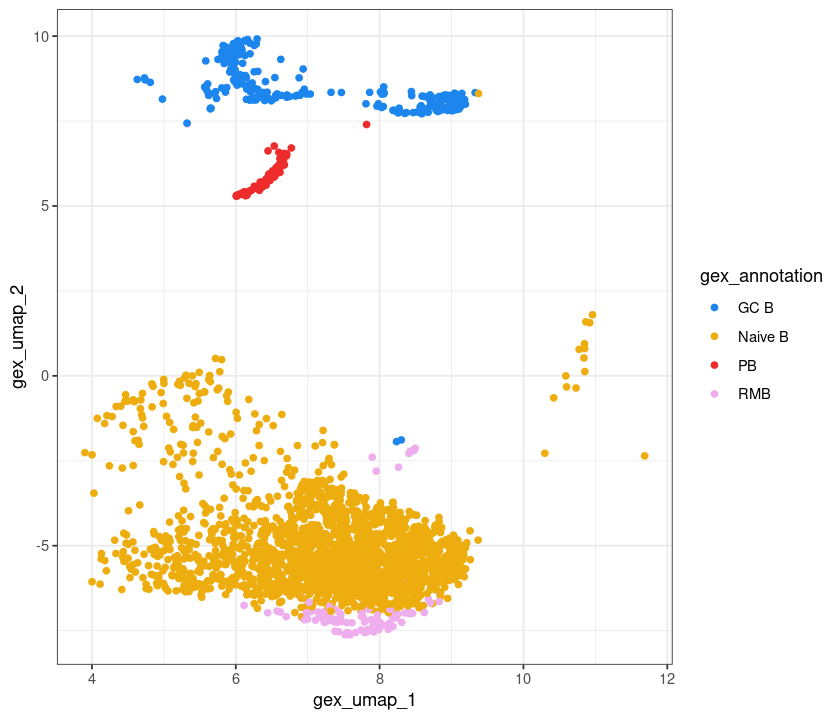

In [56]:
anno_cols <- c("GC B" = "dodgerblue2", "PB" = "firebrick2", "ABC" = "seagreen", "Naive B" = "darkgoldenrod2", "RMB" = "plum2")

options(repr.plot.width = 7, repr.plot.height = 6)
ggplot() + geom_point(data = bcr_data, aes(x = gex_umap_1, y = gex_umap_2, color = gex_annotation)) +
           scale_colour_manual(values = anno_cols) + theme_bw()

### Other BCR features in UMAPs

Characteristics associated with the BCR can also be displayed in UMAP plots. The plots below show the mutation frequencies and isotypes of GC B cells at various time points.

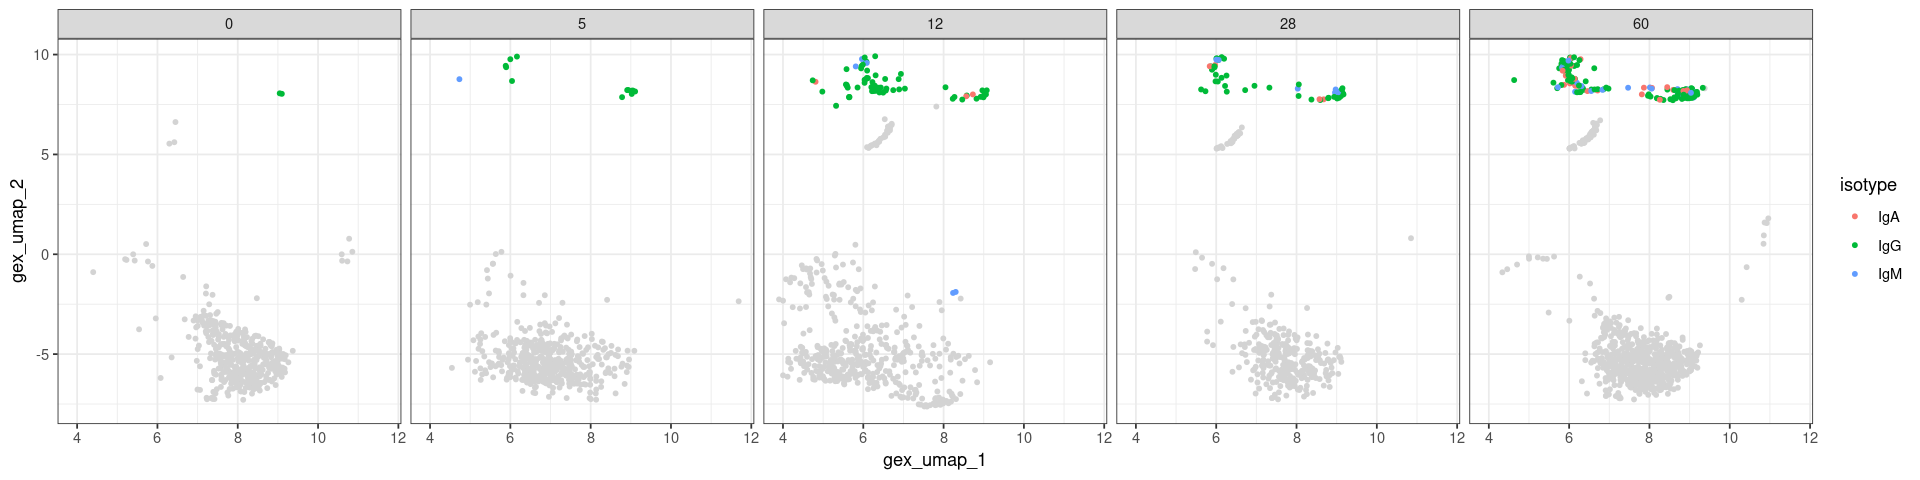

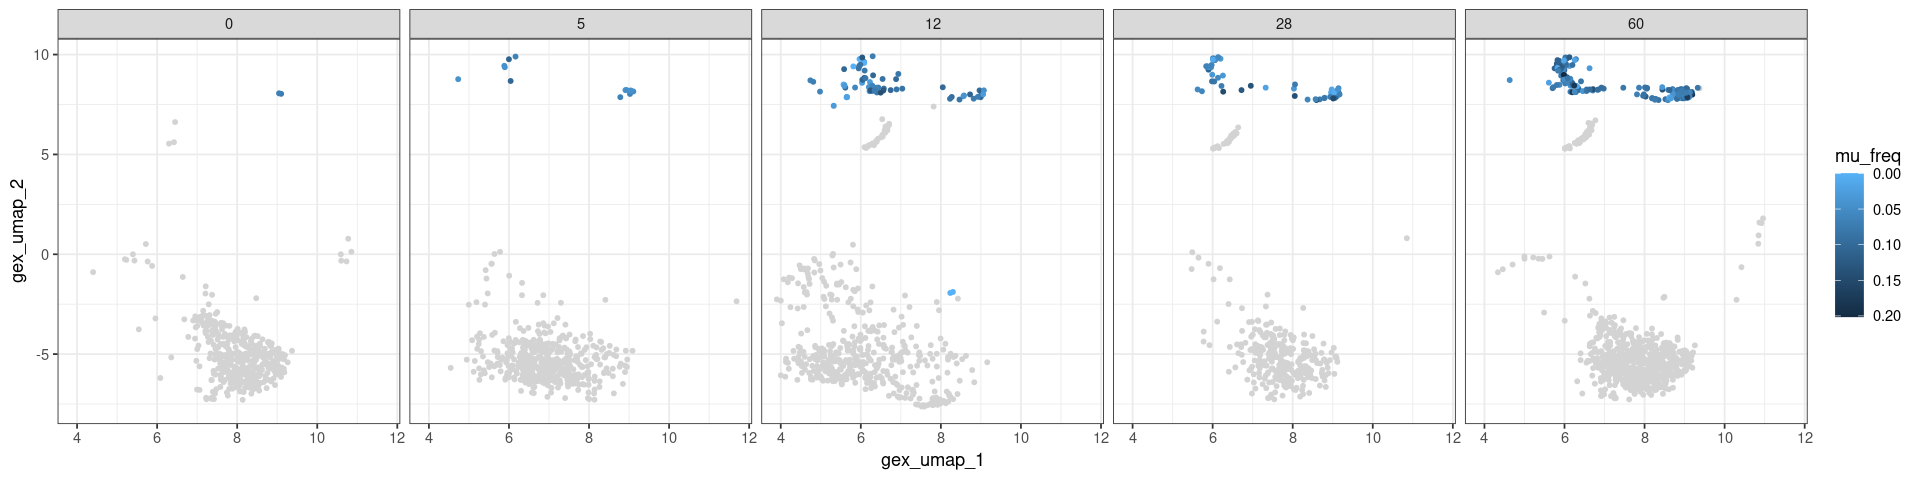

In [60]:
options(repr.plot.width = 16, repr.plot.height = 4)

# base plot
p <- ggplot() + geom_point(data = filter(bcr_data, gex_annotation != "GC B"), 
                           aes(x = gex_umap_1, y = gex_umap_2), color = "lightgray", size = 1) + 
                theme_bw() + facet_wrap(~day, nrow = 1)

# isotype information
p + geom_point(data = filter(bcr_data, gex_annotation == "GC B"), 
               aes(x = gex_umap_1, y = gex_umap_2, color = isotype), size = 1)

# mutation frequency
p + geom_point(data = filter(bcr_data, gex_annotation == "GC B"), 
               aes(x = gex_umap_1, y = gex_umap_2, color = mu_freq), size = 1) +
    scale_colour_continuous(trans = 'reverse') 